In [1]:
from pathlib import Path
import copy

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
# バージョン違いによるインポートエラーを回避
try:
    from torchvision.models import mobilenetv2
    Model = mobilenetv2.mobilenet_v2(pretrained=True)
except ImportError:
    Model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
    pass

# GPUのセットアップ
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100.0%


device(type='cuda')

In [2]:
# データセットの読み込み
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

dataset = ImageFolder("data", data_transforms['train'])
dataset.class_to_idx

{'with_mask': 0, 'without_mask': 1}

In [3]:
# 訓練用、評価用にデータを分ける
all_size = len(dataset)
train_size = int(0.8 * all_size)
val_size = all_size - train_size
dataset_size  = {"train":train_size, "val":val_size}
train_data, val_data = random_split(dataset, [train_size, val_size])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


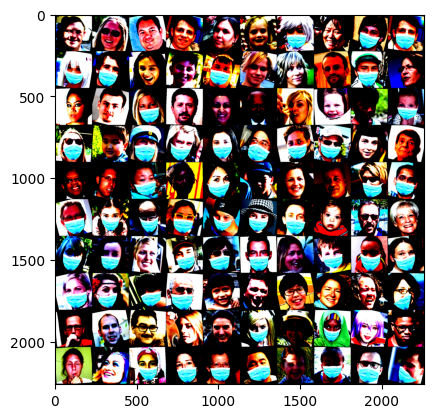

In [4]:
# DataLoaderを定義
batch_size = 100
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
dataloaders = {'train':train_loader, 'val':val_loader}

dataiter = iter(dataloaders['train'])
images, labels = next(dataiter)

# Make a grid from batch
out = torchvision.utils.make_grid(images, nrow=10)
plt.imshow(out.permute(1, 2, 0))

In [5]:
# パラメータをすべて取り出し、各層をフリーズさせる
for param in Model.parameters():
    param.requires_grad = False

In [6]:
# 今回の学習用に分類器を定義
Model.classifier[1] = nn.Sequential(
                      nn.Linear(1280, 256),
                      nn.ReLU(),
                      nn.Linear(256, 128),
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 32),
                      nn.ReLU(),
                      nn.Dropout(0.4),
                      nn.Linear(32, 2), 
                      nn.LogSoftmax(dim=1))

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Model.parameters(), lr=0.001, momentum=0.9)

In [8]:
#  CUBLAS_STATUS_ALLOC_FAILEDのエラー回避のために設定
import os 
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

model=Model.to(device)

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
best_loss = 1.0
EPOCH = 50

#途中経過保存用に、リストを持った辞書を作ります。
loss_dict ={"train" : [],  "val" : []}
acc_dict = {"train" : [],  "val" : []}

# プログラム実行前に計算を最適化(GPUを使う場合)
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True

for epoch in range(EPOCH):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(outputs, dim=1), dim=1)[1], labels).view(-1)
            running_corrects += torch.sum(correct).item()
        epoch_loss = running_loss / dataset_size[phase]
        epoch_acc = running_corrects / dataset_size[phase]
        loss_dict[phase].append(epoch_loss)
        acc_dict[phase].append(epoch_acc)
        
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        
        if phase == 'val' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    if (epoch+1)%5 == 0:#５回に１回エポックを表示
        print('Epoch {}/{}'.format(epoch+1, EPOCH))
        print('-' * 10)

model.load_state_dict(best_model_wts)
print('Best val loss: {:.4f} acc: {:.4f}'.format(best_loss, best_acc))
print('Finished Training')

train Loss: 0.6920 Acc: 0.5296
val Loss: 0.6915 Acc: 0.5318
train Loss: 0.6906 Acc: 0.5422
val Loss: 0.6905 Acc: 0.5318
train Loss: 0.6896 Acc: 0.5422
val Loss: 0.6896 Acc: 0.5318
train Loss: 0.6876 Acc: 0.5513
val Loss: 0.6887 Acc: 0.5318
train Loss: 0.6876 Acc: 0.5445
val Loss: 0.6877 Acc: 0.5318
Epoch 5/50
----------
train Loss: 0.6872 Acc: 0.5462
val Loss: 0.6863 Acc: 0.5318
train Loss: 0.6850 Acc: 0.5462
val Loss: 0.6846 Acc: 0.5318
train Loss: 0.6841 Acc: 0.5459
val Loss: 0.6821 Acc: 0.5318
train Loss: 0.6808 Acc: 0.5452
val Loss: 0.6797 Acc: 0.5318
train Loss: 0.6790 Acc: 0.5506
val Loss: 0.6762 Acc: 0.5318
Epoch 10/50
----------
train Loss: 0.6760 Acc: 0.5577
val Loss: 0.6718 Acc: 0.5318
train Loss: 0.6716 Acc: 0.5703
val Loss: 0.6662 Acc: 0.5318
train Loss: 0.6658 Acc: 0.5913
val Loss: 0.6583 Acc: 0.5332
train Loss: 0.6588 Acc: 0.6106
val Loss: 0.6480 Acc: 0.5372
train Loss: 0.6491 Acc: 0.6593
val Loss: 0.6335 Acc: 0.6847
Epoch 15/50
----------
train Loss: 0.6348 Acc: 0.7149
v

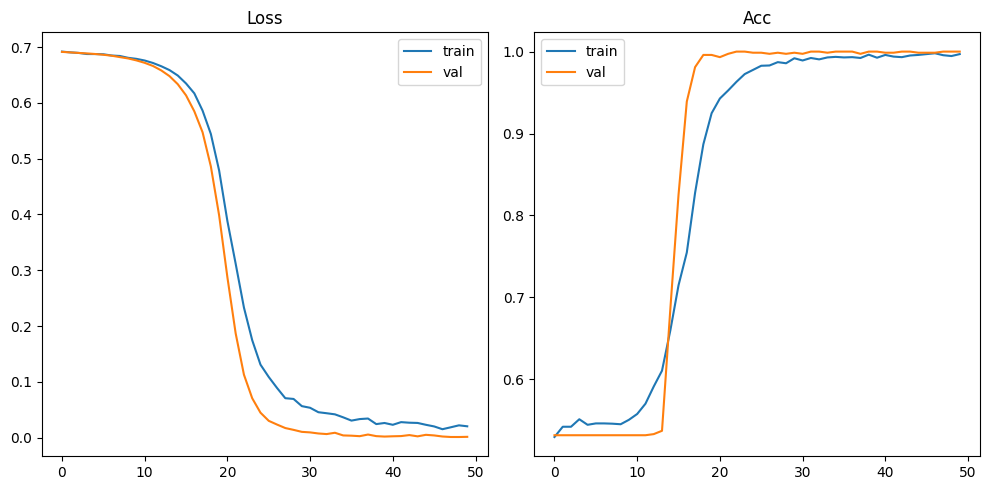

In [9]:
loss_train = loss_dict["train"]
loss_val   = loss_dict["val"]

acc_train = acc_dict["train"]
acc_val   = acc_dict["val"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

#０個目のグラフ
axes[0].plot(range(EPOCH), loss_train, label = "train")
axes[0].plot(range(EPOCH), loss_val,    label =  "val")
axes[0].set_title("Loss")
axes[0].legend()#各グラフのlabelを表示

#１個目のグラフ
axes[1].plot(range(EPOCH), acc_train, label = "train")
axes[1].plot(range(EPOCH), acc_val,    label =  "val")
axes[1].set_title("Acc")
axes[1].legend()

#０個目と１個目のグラフが重ならないように調整
fig.tight_layout()

In [10]:
# モデルの保存(pth)
torch.save(model.to('cpu'),"detector/face_mask_detector.pth")

# モデルの保存(ONNX)
trained_model = torch.load('detector/face_mask_detector.pth')
dummy_input = torch.randn(1, 3, 224, 224) 
torch.onnx.export(trained_model, dummy_input, "detector/face_mask_detector.onnx") 